# Análisis de Desastres Naturales (EM-DAT) con POO + Herencia

En este notebook vamos a:

1. Cargar y limpiar el dataset (Excel).
2. Definir clases POO para organizar el análisis.
3. Implementar **herencia** usando una clase base `AnalisisBase` que concentra validaciones comunes:
   - Verifica columnas requeridas
   - Convierte columnas numéricas de forma segura
4. Crear subclases para cada análisis del menú:
   - Muertes por tipo
   - Pérdidas económicas por tipo
   - Impacto por subtipo (muertes vs afectados)
   - K-Means por tipo (clusterización)
5. Visualizar los resultados con una clase `Visualizador`.


## 1) Imports + carga del Excel + limpieza base

- Importamos librerías.
- Cargamos el Excel con `pandas`.
- Convertimos columnas numéricas importantes.
- Detectamos automáticamente la columna de daños/pérdidas (si existe).
- Quitamos filas que no tengan `Country` o `Disaster Type` (porque son claves para los análisis).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# scikit-learn (KMeans y escalado)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Cargar datos ---
df = pd.read_excel("public_emdat_2025-12-09.xlsx")

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

# Columnas numéricas típicas (ajusta si tu Excel usa otros nombres)
columnas_numericas = ["Total Deaths", "Total Affected"]

for col in columnas_numericas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Detectar automáticamente la columna de pérdidas económicas
col_danios = None
for col in df.columns:
    if "Damage" in col or "Damages" in col:
        col_danios = col
        df[col_danios] = pd.to_numeric(df[col_danios], errors="coerce").fillna(0)
        break

print("✅ Columna de daños detectada:", col_danios)

# Eliminar registros sin país o tipo de desastre
df = df.dropna(subset=["Country", "Disaster Type"])

df.head()


✅ Columna de daños detectada: Insured Damage ('000 US$)


,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,1999-9388-DJI,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,DJI,...,NaN,NaN,0.0,NaN,NaN,NaN,56.446576,"[{""adm1_code"":1093,""adm1_name"":""Ali Sabieh""},{...",2006-03-01,2023-09-25
1,1999-9388-SDN,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SDN,...,NaN,NaN,0.0,NaN,NaN,NaN,54.895152,"[{""adm1_code"":2757,""adm1_name"":""Northern Darfu...",2006-03-08,2023-09-25
2,1999-9388-SOM,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SOM,...,NaN,NaN,0.0,NaN,NaN,NaN,54.895152,"[{""adm1_code"":2691,""adm1_name"":""Bay""},{""adm1_c...",2006-03-08,2023-09-25
3,2000-0001-AGO,No,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,NaN,AGO,...,NaN,NaN,0.0,NaN,NaN,NaN,54.895152,NaN,2004-10-27,2023-09-25
4,2000-0002-AGO,No,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,AGO,...,NaN,NaN,0.0,NaN,10000.0,18217.0,54.895152,"[{""adm2_code"":4214,""adm2_name"":""Baia Farta""},{...",2005-02-03,2023-09-25


## 2) Clase `DesastresNaturales` (Modelo)

Esta clase representa el dataset de desastres y da métodos "base" del dominio:

- Tabla por país (cuántos desastres por país)
- Tipos de desastre más frecuentes
- Filtro por tipo de desastre (ej. "Flood", "Earthquake")

Esto mantiene el código del menú limpio y separa responsabilidades.


In [2]:
class DesastresNaturales:
    def __init__(self, dataframe):
        self.df = dataframe

    def tabla_por_pais(self):
        if self.df.empty:
            return pd.DataFrame()
        return (
            self.df["Country"]
            .value_counts()
            .reset_index(name="Cantidad de Desastres")
            .rename(columns={"index": "País"})
        )

    def tipos_frecuentes(self):
        if self.df.empty:
            return pd.Series(dtype=int)
        return self.df["Disaster Type"].value_counts()

    def filtrar_desastre(self, tipo):
        # Manejo seguro de NaN para evitar errores
        return self.df[self.df["Disaster Type"].fillna("").str.lower() == tipo.lower()]


## 3) Herencia en análisis: Clase base `AnalisisBase`

Aquí implementamos la **herencia**:

- `AnalisisBase` es una clase abstracta que concentra lógica común:
  - Validar que existan columnas necesarias (`required_cols`)
  - Convertir columnas a numéricas de forma segura
- Las subclases heredan estas capacidades y solo implementan `calcular()`.

Esto aplica varios principios:
- **DRY**: no repetimos validaciones en cada análisis.
- **SRP**: cada subclase hace un análisis específico.
- **Open/Closed**: puedes agregar nuevos análisis creando otra subclase sin modificar las existentes.
- **Polimorfismo**: todas las subclases exponen el mismo método `calcular()`.


In [3]:
from abc import ABC, abstractmethod

class AnalisisBase(ABC):
    required_cols = []

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def _check_required(self):
        faltantes = [c for c in self.required_cols if c not in self.df.columns]
        if faltantes:
            raise ValueError(f"Faltan columnas requeridas: {faltantes}")

    def _coerce_numeric(self, cols):
        for c in cols:
            if c in self.df.columns:
                self.df[c] = pd.to_numeric(self.df[c], errors="coerce").fillna(0)

    @abstractmethod
    def calcular(self):
        """Devuelve el resultado del análisis (Series o DataFrame)."""
        pass


## 4) Subclase: Muertes por tipo de desastre (opción 3 del menú)

Esta clase hereda de `AnalisisBase` y calcula:

- Suma total de muertes (`Total Deaths`) agrupado por `Disaster Type`
- Ordenado de mayor a menor

La herencia aporta:
- Validación automática de columnas requeridas
- Conversión numérica segura


In [4]:
class AnalisisMuertesPorTipo(AnalisisBase):
    required_cols = ["Disaster Type", "Total Deaths"]

    def calcular(self):
        self._check_required()
        self._coerce_numeric(["Total Deaths"])

        return (
            self.df.groupby("Disaster Type")["Total Deaths"]
            .sum()
            .sort_values(ascending=False)
        )


## 5) Subclase: Pérdidas económicas por tipo (opción 4 del menú)

Esta clase hereda de `AnalisisBase` pero necesita una columna dinámica:

- La columna de daños (`col_danios`) se detecta automáticamente en la carga del Excel.
- Si no existe, regresa una serie vacía para evitar fallas.

Luego:
- Agrupa por `Disaster Type`
- Suma las pérdidas
- Ordena de mayor a menor


In [5]:
class AnalisisPerdidasPorTipo(AnalisisBase):
    def __init__(self, df, col_danios):
        super().__init__(df)
        self.col_danios = col_danios
        self.required_cols = ["Disaster Type", col_danios] if col_danios else ["Disaster Type"]

    def calcular(self):
        if not self.col_danios:
            return pd.Series(dtype=float)

        self._check_required()
        self._coerce_numeric([self.col_danios])

        return (
            self.df.groupby("Disaster Type")[self.col_danios]
            .sum()
            .sort_values(ascending=False)
        )


## 6) Subclase: Impacto humano por subtipo (opción 5 del menú)

Esta clase prepara una tabla por `Disaster Subtype` con:

- `Total Deaths` (suma)
- `Total Affected` (suma)

Esto se usa para comparar subtipos dentro de un tipo específico (por ejemplo, solo Flood).


In [6]:
class AnalisisImpactoPorSubtipo(AnalisisBase):
    required_cols = ["Disaster Subtype", "Total Deaths", "Total Affected"]

    def calcular(self):
        self._check_required()
        self._coerce_numeric(["Total Deaths", "Total Affected"])

        tabla = (
            self.df.dropna(subset=["Disaster Subtype"])
            .groupby("Disaster Subtype")[["Total Deaths", "Total Affected"]]
            .sum()
            .reset_index()
        )
        return tabla


## 7) Subclase: K-Means por tipo (opción 6 del menú)

Aquí aplicamos **machine learning** para agrupar tipos de desastre en clusters.

Pasos:
1. Agrupamos por `Disaster Type` sumando muertes y afectados.
2. Sumamos un `epsilon` para evitar ceros (útil para escalas log y estabilidad).
3. Escalamos variables con `StandardScaler` (KMeans es sensible a escala).
4. Aplicamos `KMeans` y asignamos el cluster a cada tipo.


In [7]:
class AnalisisKMeansPorTipo(AnalisisBase):
    required_cols = ["Disaster Type", "Total Deaths", "Total Affected"]

    def calcular(self, k=3, epsilon=1):
        self._check_required()
        self._coerce_numeric(["Total Deaths", "Total Affected"])

        df_group = (
            self.df.groupby("Disaster Type")[["Total Deaths", "Total Affected"]]
            .sum()
        )

        df_group["Total Deaths"] += epsilon
        df_group["Total Affected"] += epsilon

        X = df_group[["Total Deaths", "Total Affected"]]
        X_scaled = StandardScaler().fit_transform(X)

        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        df_group["Cluster"] = km.fit_predict(X_scaled)

        return df_group


## 8) Clase `Visualizador` (Vista)

Esta clase se encarga de **mostrar** resultados:

- Tablas (con `display`)
- Gráfica de barras (Series)
- Comparación Muertes vs Afectados por subtipo (escala log)
- Scatter de clusters K-Means (escala log)

Separar esto cumple SRP: análisis calcula, visualizador muestra.


In [8]:
class Visualizador:

    def tabla(self, df):
        if df is None or (hasattr(df, "empty") and df.empty):
            print("⚠️ No hay datos para mostrar.")
            return
        display(df)

    def grafica_barras(self, serie, titulo, ylabel, log=False, epsilon=1e-9):
        if serie is None or len(serie) == 0:
            print("⚠️ No hay datos para generar la gráfica.")
            return

        # Copia para no modificar la original
        serie_plot = serie.copy()

        # Convertir a numérico seguro
        serie_plot = pd.to_numeric(serie_plot, errors="coerce").fillna(0)

        # Evitar problemas con escala log (no permite 0)
        if log:
            serie_plot = serie_plot.clip(lower=0) + epsilon

        serie_plot.plot(kind="bar", figsize=(10, 5))

        if log:
            plt.yscale("log")

        plt.title(titulo)
        plt.ylabel(ylabel + (" (log)" if log else ""))
        plt.xlabel("Categoría")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    def grafica_afectados_vs_muertes(self, df_filtrado):
        if df_filtrado is None or df_filtrado.empty:
            print("⚠️ No hay datos para graficar")
            return

        # Prepara tabla con la clase de análisis por subtipo
        analisis = AnalisisImpactoPorSubtipo(df_filtrado)
        tabla = analisis.calcular()

        if tabla.empty:
            print("⚠️ No hay datos agrupados")
            return

        tabla = tabla.rename(columns={
            "Total Deaths": "muertes_totales",
            "Total Affected": "afectados_totales"
        }).sort_values("afectados_totales", ascending=True)

        x = np.arange(len(tabla))
        w = 0.4

        plt.figure(figsize=(10, 4))
        plt.bar(x - w/2, tabla["muertes_totales"], width=w, label="Muertes")
        plt.bar(x + w/2, tabla["afectados_totales"], width=w, label="Afectados")

        plt.yscale("log")
        plt.xticks(x, tabla["Disaster Subtype"], rotation=20, ha="right")
        plt.title("Muertes vs Afectados por subtipo (escala log)")
        plt.ylabel("Total (log)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def grafica_kmeans_por_tipo(self, tabla):
        if tabla is None or tabla.empty:
            print("⚠️ No hay datos para K-Means")
            return

        plt.figure(figsize=(9, 6))
        for cluster in sorted(tabla["Cluster"].unique()):
            datos = tabla[tabla["Cluster"] == cluster]
            plt.scatter(
                datos["Total Deaths"],
                datos["Total Affected"],
                label=f"Cluster {cluster}",
                s=100
            )

        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Muertes Totales (log)")
        plt.ylabel("Afectados Totales (log)")
        plt.title("K-Means por Tipo de Desastre (Impacto Humano)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def grafica_linea(self, serie, titulo, ylabel, log=False, epsilon=1e-9):
        if serie is None or len(serie) == 0:
            print("⚠️ No hay datos para generar la gráfica.")
            return

        serie_plot = pd.to_numeric(serie, errors="coerce").fillna(0)

        if log:
            serie_plot = serie_plot.clip(lower=0) + epsilon

        plt.figure(figsize=(10, 5))
        plt.plot(serie_plot.index, serie_plot.values, marker="o")
        if log:
            plt.yscale("log")

        plt.title(titulo)
        plt.xlabel("Año")
        plt.ylabel(ylabel + (" (log)" if log else ""))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    def grafica_correlacion(self, corr_df, titulo="Matriz de correlación"):
        if corr_df is None or corr_df.empty:
            print("⚠️ No hay suficientes columnas numéricas para correlación.")
            return

        plt.figure(figsize=(8, 6))
        im = plt.imshow(corr_df.values)  # colormap default
        plt.colorbar(im, fraction=0.046, pad=0.04)

        plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=45, ha="right")
        plt.yticks(range(len(corr_df.index)), corr_df.index)

        plt.title(titulo)
        plt.tight_layout()
        plt.show()

        # opcional: mostrar la tabla también
        display(corr_df)



In [9]:
class AnalisisTopPaises(AnalisisBase):
    required_cols = ["Country"]

    def calcular(self, metrica="deaths", top=10, col_danios=None):
        """
        metrica: "deaths" | "affected" | "damages"
        top: int
        col_danios: nombre de columna de daños (si metrica="damages")
        """
        self._check_required()

        metrica = metrica.strip().lower()

        if metrica == "deaths":
            col = "Total Deaths"
            self.required_cols = ["Country", col]
            self._check_required()
            self._coerce_numeric([col])

        elif metrica == "affected":
            col = "Total Affected"
            self.required_cols = ["Country", col]
            self._check_required()
            self._coerce_numeric([col])

        elif metrica == "damages":
            if not col_danios:
                return pd.Series(dtype=float)
            col = col_danios
            self.required_cols = ["Country", col]
            self._check_required()
            self._coerce_numeric([col])

        else:
            raise ValueError("Métrica inválida. Usa: deaths | affected | damages")

        serie = (
            self.df.dropna(subset=["Country"])
            .groupby("Country")[col]
            .sum()
            .sort_values(ascending=False)
            .head(int(top))
        )

        return serie


class AnalisisTendenciaAnual(AnalisisBase):
    """
    Detecta el año automáticamente a partir de columnas comunes:
    - 'Year'
    - 'Start Year'
    - alguna columna tipo fecha (ej. 'Start Date')
    """
    def _detectar_columna_anio(self):
        cols_lower = {c.lower().strip(): c for c in self.df.columns}

        # Preferencias directas
        for key in ["year", "start year", "start_year", "startyear"]:
            if key in cols_lower:
                return cols_lower[key], "year"

        # Buscar una columna de fecha probable
        for c in self.df.columns:
            cl = c.lower()
            if ("date" in cl) and ("start" in cl or "begin" in cl):
                return c, "date"

        # Último intento: cualquier columna que contenga 'year'
        for c in self.df.columns:
            if "year" in c.lower():
                return c, "year"

        return None, None

    def _obtener_serie_anio(self):
        col, kind = self._detectar_columna_anio()
        if col is None:
            raise ValueError("No pude detectar una columna de año/fecha en el dataset.")

        if kind == "date":
            dt = pd.to_datetime(self.df[col], errors="coerce")
            return dt.dt.year
        else:
            return pd.to_numeric(self.df[col], errors="coerce")

    def calcular(self, metrica="deaths", col_danios=None):
        metrica = metrica.strip().lower()

        # Año
        year = self._obtener_serie_anio()
        df2 = self.df.copy()
        df2["__year__"] = year
        df2 = df2.dropna(subset=["__year__"])
        df2["__year__"] = df2["__year__"].astype(int)

        # Métrica
        if metrica == "deaths":
            col = "Total Deaths"
            self._coerce_numeric([col])
        elif metrica == "affected":
            col = "Total Affected"
            self._coerce_numeric([col])
        elif metrica == "damages":
            if not col_danios:
                return pd.Series(dtype=float)
            col = col_danios
            self._coerce_numeric([col])
        else:
            raise ValueError("Métrica inválida. Usa: deaths | affected | damages")

        serie = (
            df2.groupby("__year__")[col]
            .sum()
            .sort_index()
        )

        return serie


In [10]:
class AnalisisCorrelacion(AnalisisBase):
    def calcular(self, cols=None, usar_log1p=True, metodo="pearson"):
        """
        cols: lista de columnas numéricas a usar. Si None, usa las típicas si existen.
        usar_log1p: aplica log(1+x) a las columnas para reducir sesgo/outliers.
        metodo: 'pearson' (lineal) o 'spearman' (monótona, más robusta)
        """
        if cols is None:
            candidatos = [
                "Total Deaths",
                "Total Affected",
                "Total Injured",
                "Total Homeless",
            ]
            cols = [c for c in candidatos if c in self.df.columns]

        # incluir daños si existe y el usuario ya detectó col_danios
        # (si quieres forzarlo, pásalo en cols desde el menú)
        if len(cols) < 2:
            return pd.DataFrame()

        # convertir a numérico seguro
        self._coerce_numeric(cols)

        X = self.df[cols].copy()

        if usar_log1p:
            X = np.log1p(X.clip(lower=0))

        corr = X.corr(method=metodo)
        return corr



MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


,Country,Cantidad de Desastres
0,China,1374
1,India,842
2,United States of America,737
3,Indonesia,584
4,Philippines,488
...,...,...
218,Saint Barthélemy,1
219,Sint Maarten (Dutch part),1
220,Curaçao,1
221,Liechtenstein,1



MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


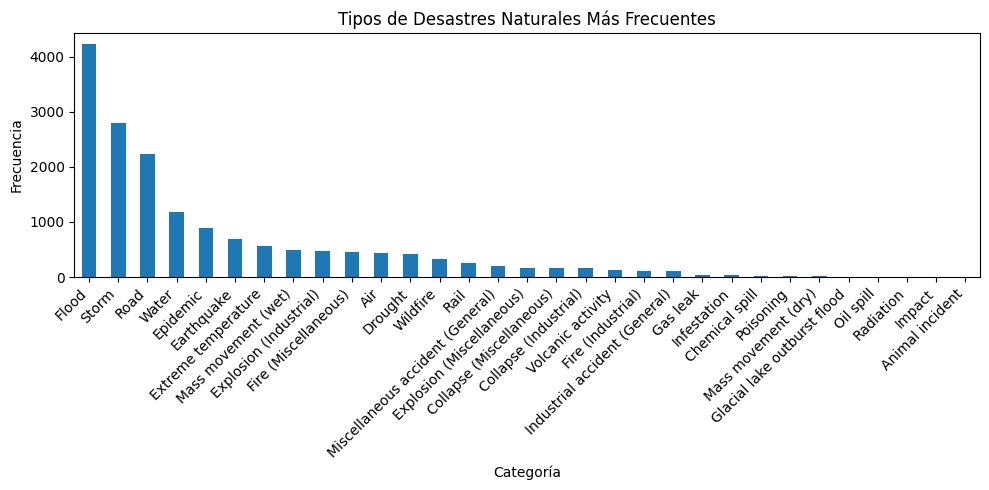


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


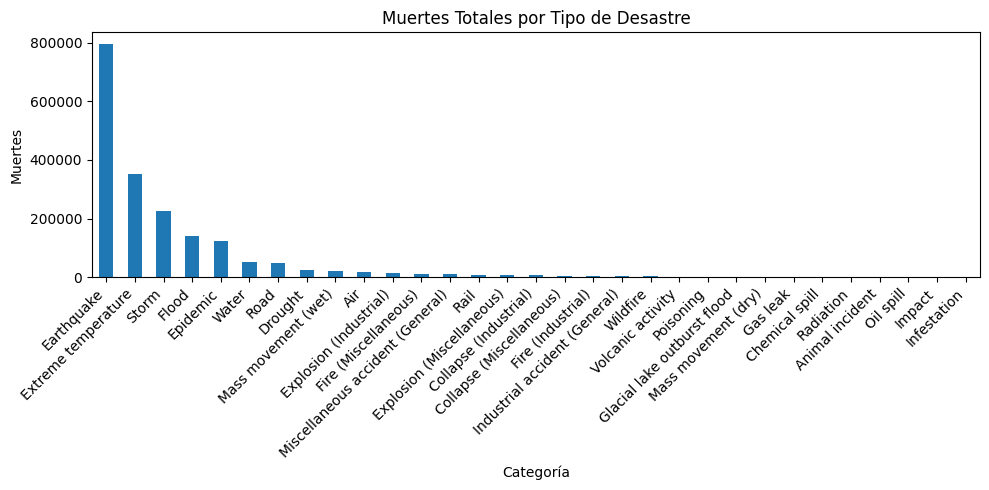


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


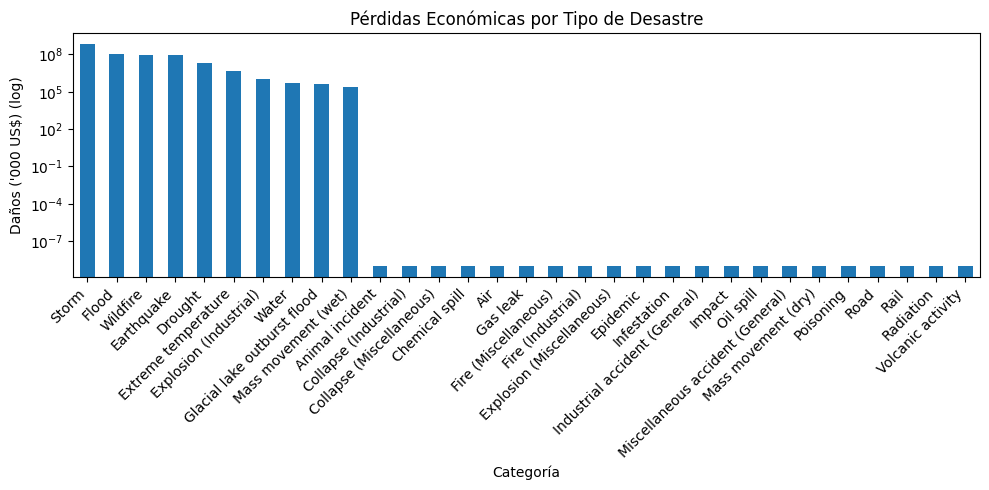


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


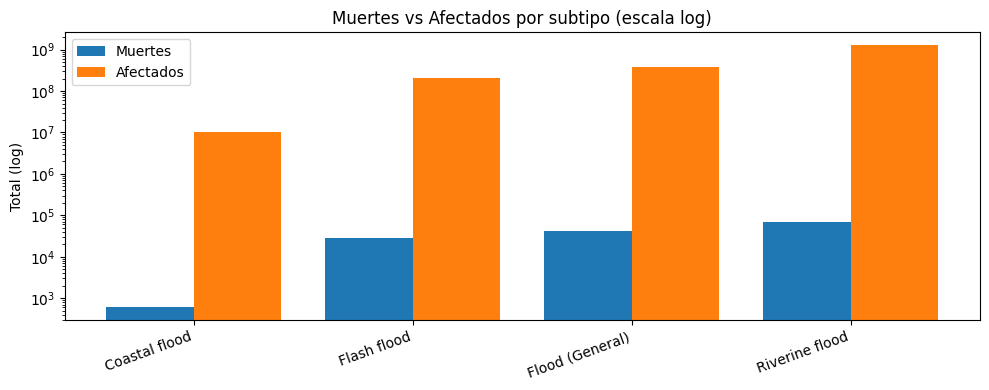


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


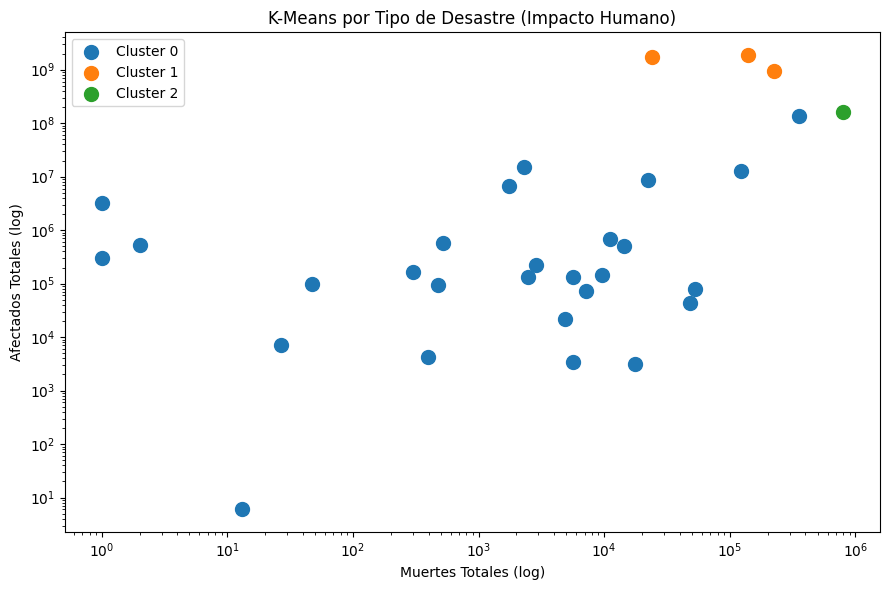


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


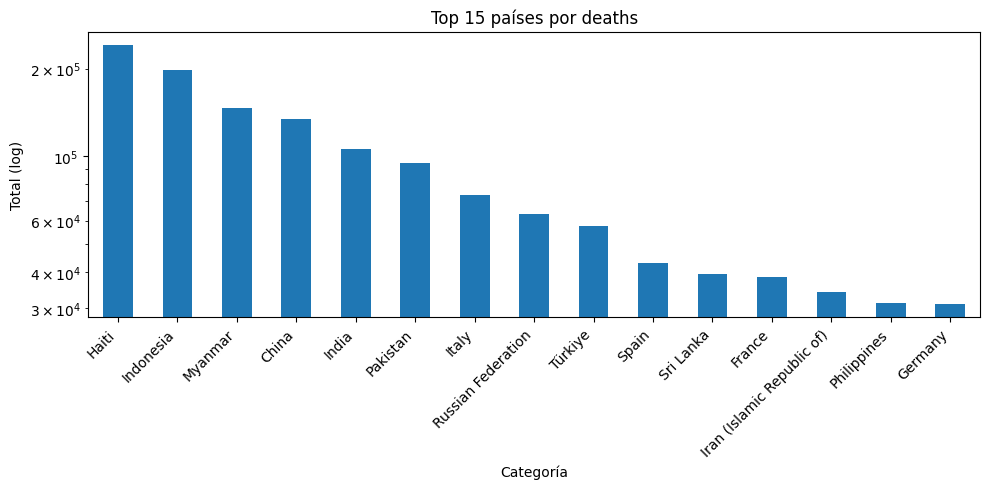


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


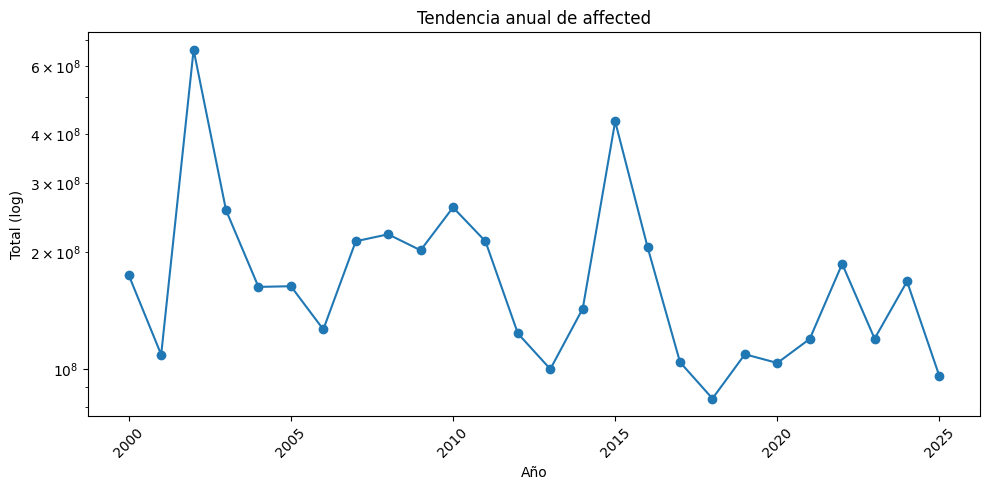


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


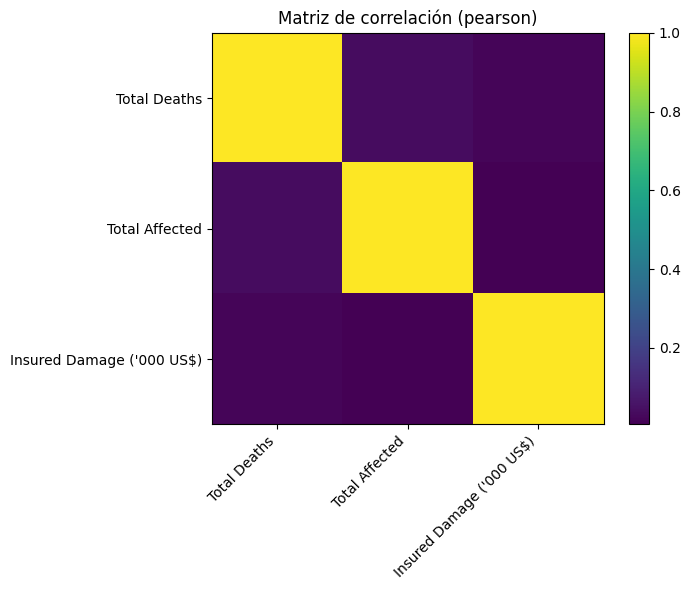

,Total Deaths,Total Affected,Insured Damage ('000 US$)
Total Deaths,1.000000,0.037743,0.020013
Total Affected,0.037743,1.000000,0.005318
Insured Damage ('000 US$),0.020013,0.005318,1.000000



MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


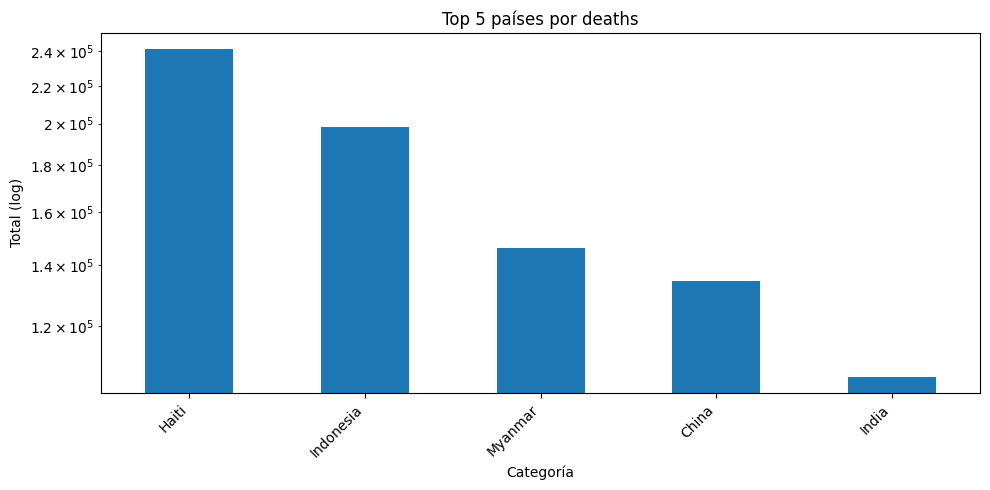


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir


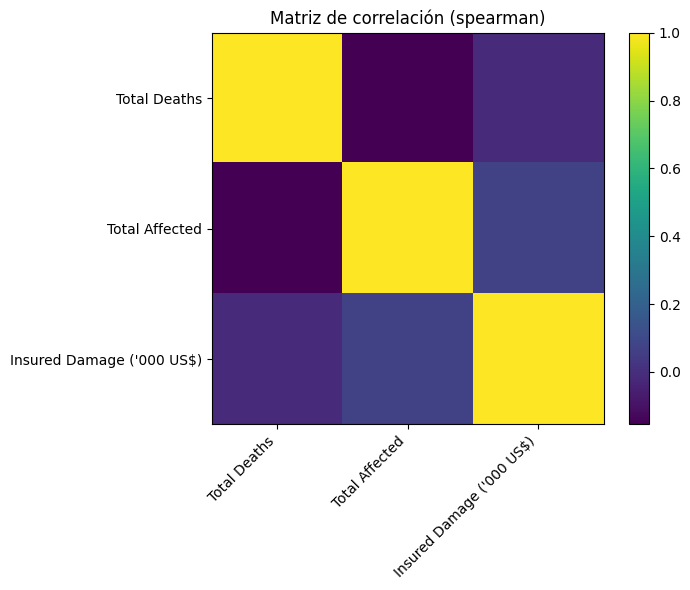

,Total Deaths,Total Affected,Insured Damage ('000 US$)
Total Deaths,1.000000,-0.155235,-0.017503
Total Affected,-0.155235,1.000000,0.067074
Insured Damage ('000 US$),-0.017503,0.067074,1.000000



MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Top N países por muertes/afectados/pérdidas
8. Tendencia por año (muertes/afectados/pérdidas)
9. Matriz de correlación (numéricas)
10. Salir
Programa finalizado correctamente.


In [11]:
desastres = DesastresNaturales(df)
viz = Visualizador()

while True:
    print("\nMENÚ – ANÁLISIS DE DESASTRES NATURALES")
    print("1. Tabla de desastres por países")
    print("2. Gráfica del tipo de desastre más frecuente")
    print("3. Gráfica de desastres que causan más muertes")
    print("4. Gráfica de desastres con mayor pérdida económica")
    print("5. Análisis por subtipos (muertes y afectados)")
    print("6. Análisis K-Means")
    print("7. Top N países por muertes/afectados/pérdidas")
    print("8. Tendencia por año (muertes/afectados/pérdidas)")
    print("9. Matriz de correlación (numéricas)")
    print("10. Salir")

    opcion = input("Selecciona una opción: ").strip()

    if opcion == "1":
        viz.tabla(desastres.tabla_por_pais())

    elif opcion == "2":
        viz.grafica_barras(
            desastres.tipos_frecuentes(),
            "Tipos de Desastres Naturales Más Frecuentes",
            "Frecuencia"
        )

    elif opcion == "3":
        analisis = AnalisisMuertesPorTipo(df)
        serie = analisis.calcular()
        viz.grafica_barras(
            serie,
            "Muertes Totales por Tipo de Desastre",
            "Muertes"
        )

    elif opcion == "4":
        analisis = AnalisisPerdidasPorTipo(df, col_danios)
        serie = analisis.calcular()
        viz.grafica_barras(
            serie,
            "Pérdidas Económicas por Tipo de Desastre",
            "Daños ('000 US$)",
            log=True  # (si ya agregaste el parámetro log en tu grafica_barras)
        )

    elif opcion == "5":
        tipo = input("Escribe el tipo de desastre (ej. Flood, Earthquake): ").strip()
        df_filtrado = desastres.filtrar_desastre(tipo)

        if df_filtrado.empty:
            print("No existen registros para ese tipo de desastre.")
            continue

        viz.grafica_afectados_vs_muertes(df_filtrado)

    elif opcion == "6":
        analisis = AnalisisKMeansPorTipo(df)
        resultado = analisis.calcular(k=3)
        viz.grafica_kmeans_por_tipo(resultado)

    elif opcion == "7":
        metrica = input("Métrica (deaths/affected/damages): ").strip().lower()
        top = input("Top N (ej. 10): ").strip()
        top = int(top) if top.isdigit() else 10

        analisis = AnalisisTopPaises(df)
        serie = analisis.calcular(metrica=metrica, top=top, col_danios=col_danios)

        if serie is None or len(serie) == 0:
            print("⚠️ No hay datos para esa métrica (o no existe col_danios).")
            continue

        titulo = f"Top {top} países por {metrica}"
        ylabel = "Total"
        viz.grafica_barras(serie, titulo, ylabel, log=True)

    elif opcion == "8":
        metrica = input("Métrica (deaths/affected/damages): ").strip().lower()

        analisis = AnalisisTendenciaAnual(df)
        serie = analisis.calcular(metrica=metrica, col_danios=col_danios)

        if serie is None or len(serie) == 0:
            print("⚠️ No hay datos para esa métrica (o no existe col_danios).")
            continue

        viz.grafica_linea(
            serie,
            f"Tendencia anual de {metrica}",
            "Total",
            log=True
        )

    elif opcion == "9":
        metodo = input("Método (pearson/spearman) [pearson]: ").strip().lower() or "pearson"
        usar_log = input("¿Usar log1p? (s/n) [s]: ").strip().lower() or "s"
        usar_log1p = (usar_log == "s")

        # columnas por default + daños si existe
        cols = ["Total Deaths", "Total Affected"]
        for extra in ["Total Injured", "Total Homeless"]:
            if extra in df.columns:
                cols.append(extra)
        if col_danios:
            cols.append(col_danios)

        analisis = AnalisisCorrelacion(df)
        corr = analisis.calcular(cols=cols, usar_log1p=usar_log1p, metodo=metodo)

        titulo = f"Matriz de correlación ({metodo})" + (" con log1p" if usar_log1p else "")
        viz.grafica_correlacion(corr, titulo=titulo)

    elif opcion == "10":
        print("Programa finalizado correctamente.")
        break


    else:
        print("Opción inválida. Intenta nuevamente.")
